# Implementing a PINN to solve the parabolic wave guide

### The paraxial wave equation

$\newcommand{\pa}{\partial}
\newcommand{\ppx}{\frac{\partial}{\partial x}}
\newcommand{\ppz}{\frac{\partial}{\partial z}}
\newcommand{\ppxz}{\frac{\partial^2}{\partial x^2}}$

The parabolic wave guide is described by

$$ \frac{\partial^2 }{\partial x^2} A(x,z) + 2in_0 k_0 \partial_z A(x,z) - 2an_0k_0^2 x^2 A(x,z) = 0, $$

Now we separate the PDE into real and imaginary part, where $A(x,z) := u(x,z) + i\cdot v(x,z)$:

$$ \frac{\partial^2 }{\partial x^2}u(x,z) + i \ppxz v(x,z) + 2in_0 k_0 \partial_z u(x,z) - 2 n_0 k_0 \partial_z v(x,z) - 2an_0k_0^2 x^2 u(x,z) - 2i an_0 k_0^2x^2v(x,z) = 0 $$

going further,

$$ \frac{\partial^2 }{\partial x^2}u(x,z)  - 2 n_0 k_0 \partial_z v(x,z) - 2an_0k_0^2 x^2 u(x,z) + i \left( \ppxz v(x,z) + 2 n_0 k_0 \partial_z u(x,z) - 2 an_0 k_0^2x^2v(x,z) \right) = 0 $$

yielding

\begin{align}
0 &=  \frac{\partial^2 }{\partial x^2} u(x,z) - 2an_0k_0^2 x^2 u(x,z) - 2n_0k_0\partial_z v(x,z) \\
0 &=  \frac{\partial^2 }{\partial x^2} v(x,z) - 2an_0k_0^2 x^2 v(x,z) + 2n_0k_0\partial_z u(x,z)
\end{align}

### Reference solution: The paraxial wave

The reference solution is

$$ A(x,z) = \sum_n c_n g_n(x) \exp[- iM_n z / (2n_0 k_0)] $$

where

$$ M_n = k_0 \sqrt{8an_0} (n + 1/2) $$

and 

$$ g_n(x) = \frac{1}{\sqrt{2^n n!}} \left( k_0 \sqrt{2an_0} / \pi \right)^{1/4} \ \exp[- k_0 x^2 \sqrt{2an_0}/2] \ H_n ((2an_0k_0^2)^{1/4} x) $$

with

\begin{align}
H_n (z) &= 2zH_{n-1} (z) - 2(n-1)H_{n-2}(z) \\
H_1(z) &= 2z \\
H_0 (z) &= 1
\end{align}

#### Boundary conditions

We choose as boundaries $x \in [-1,1]$ and $z \in [0,1]$. This gives

\begin{align}
u(\pm 1, z) &\approx 0 \\
v(\pm 1, z) &\approx 0
\end{align}

and

\begin{align}
u(x,0) &= \mathrm{Re}\{ A(x,0) \} \\
v(x,0) &= \mathrm{Im}\{ A(x,0) \} 
\end{align}

#### Choosing the physical parameters

We choose $n_0 = 1$, $a = 0.1$ and $k = 50$. The reason can be simply explained by plotting the solution (see a little later).

We choose $c = (0.1, \: 0.4, \: 0.3 i, \: 0, \: 0.2i)$.

### Implementation - Hyperparameters

We use $4$ layers with $32$ nodes each.

# Code

### Importing stuff

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
from time import time

### Setting seed, backend and other setup conveniences

In [3]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [4]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

In [5]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [6]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

In [7]:
images = []  # container to store output images in order to create GIF

In [8]:
mpl.matplotlib_fname() # sanity check - where's my matplotlibrc

'C:\\Users\\Jakob\\.matplotlib\\matplotlibrc'

### Setting physical constants

In [141]:
n_0 = 1.
k = 50.
a = 0.1
limit = 5

c = np.zeros(limit).astype(np.complex64)
    
c[1] = 0.1
#c[1] = 0.4
#c[2] = 0.3j
#c[4] = 0.2j

c_norm = np.copy(c) / np.sqrt(np.sum(np.abs(c)**2))

x_lb = -1.
x_ub = 1.

z_lb = 0.
z_ub = 1.

### Plotting the solution beforehand

In [142]:
def hermite(z, n):
    if n < 0:
        print('fuck you are fucked')
    if n == 0:
        return 1
    elif n == 1:
        return 2 * z
    else:
        return 2 * z * hermite(z, n-1) - 2 * (n-1) * hermite(z, n-2)

In [143]:
def hermite_ar(z, n):
    if n < 0:
        print('fuck you are fucked')
    if n == 0:
        return np.ones(len(z))
    elif n == 1:
        return 2 * z
    else:
        return 2 * z * hermite(z, n-1) - 2 * (n-1) * hermite(z, n-2)

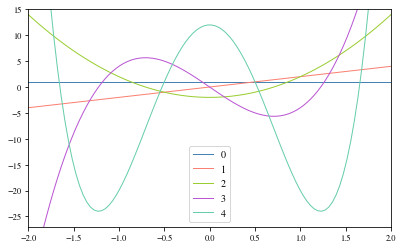

In [144]:
hermite_z = np.linspace(-2., 2., num=100)

fig, ax = plt.subplots(1)
for i in range(5):
    y_htest = hermite_ar(hermite_z, int(i))
    ax.plot(hermite_z, y_htest, label=str(i))
ax.legend(loc='best')
ax.set_ylim(-27,15)
ax.set_xlim(-2,2)
plt.show()

In [145]:
plt.close()

In [146]:
def g(x,n):
    pre1= 1 / np.sqrt(2**n * np.math.factorial(n))
    pre2 = ( k / np.pi * np.sqrt(2 * a * n_0))**(0.25)
    gauss = np.exp(- 0.5 * k * x**2 * np.sqrt(2 * a * n_0))
    argument = (2 * a * n_0 * k**2)**(0.25) * x
    return pre1 * pre2 * gauss * hermite(argument, n)

In [147]:
def M(n):
    return k * np.sqrt(8 * a * n_0) * (n + 0.5)

In [148]:
def phase(z,n):
    argument = - M(n) * z / (2 * n_0 * k)
    return np.exp(argument * 1j)

In [149]:
def solution(x_ar, z_ar, coeff, limit):
    sol = np.empty((len(z_ar), len(x_ar))).astype(np.complex64)
    for i,x in enumerate(x_ar):
        for j,z in enumerate(z_ar):
            sol[j,i] = 0
            for n in range(limit):
                sol[j,i] += coeff[n] * g(x,n) * phase(z,n)
    return sol

In [150]:
def initial_solution(x_ar, coeff, limit):
    isol = np.empty(len(x_ar)).astype(np.complex64)
    for i,x in enumerate(x_ar):
        isol[i] = 0
        for n in range(limit):
            isol[i] += coeff[n] * g(x,n)
    return isol

In [151]:
x_np = np.linspace(-1, 1, num=100)
z_np = np.linspace(0, 1, num=100)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

numpy_solution = solution(x_np, z_np, c_norm, limit)
numpy_solution_sq = np.abs(numpy_solution)**2
numpy_isolution = initial_solution(x_np, c_norm, limit)
numpy_isolution_sq = np.abs(numpy_isolution)**2

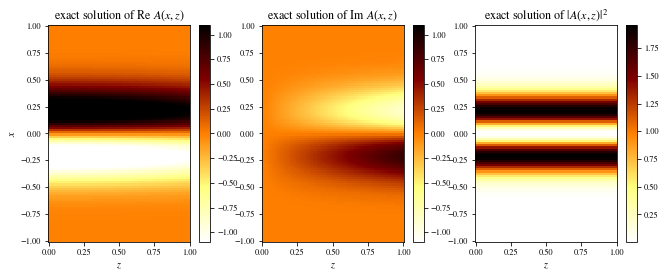

In [152]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,4))

line1 = ax1.pcolormesh(z_npmesh, x_npmesh, np.real(numpy_solution), cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of Re $A(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
#cmap1.set_label('Re $A(x,z)$')

line2 = ax2.pcolormesh(z_npmesh, x_npmesh, np.imag(numpy_solution), cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
ax2.set_xlabel('$z$')
#ax2.set_ylabel('$x$')
ax2.set_title('exact solution of Im $A(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
#cmap2.set_label('Im $A(x,z)$')

line3 = ax3.pcolormesh(z_npmesh, x_npmesh, numpy_solution_sq, cmap = cm.afmhot_r)
ax3.set_xlabel('$z$')
#ax3.set_ylabel('$x$')
ax3.set_title(r'exact solution of $|A(x,z)|^2$')
cmap3 = fig.colorbar(line3, ax=ax3)
#cmap3.set_label(r'$|A(x,z)|^2$')

plt.show()

In [153]:
plt.close()

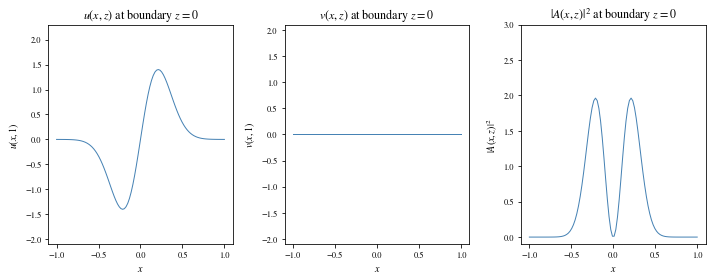

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,4))

ax1.plot(x_npmesh[0,:], np.real(numpy_isolution))
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(x,1)$')
ax1.set_ylim(-2.1, 2.3)
ax1.set_title('$u(x,z)$ at boundary $z=0$')

ax2.plot(x_npmesh[0,:], np.imag(numpy_isolution))
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x,1)$')
ax2.set_ylim(-2.1, 2.1)
ax2.set_title('$v(x,z)$ at boundary $z=0$')

ax3.plot(x_npmesh[0,:], numpy_isolution_sq)
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$|A(x,z)|^2$')
ax3.set_ylim(-0.1, 3)
ax3.set_title(r'$|A(x,z)|^2$ at boundary $z=0$')

fig.tight_layout()

plt.show()

In [155]:
plt.close()

In [156]:
print(np.sum(numpy_solution_sq[28,:])*(x_np[1]-x_np[0]))

1.0000000000000009


In [157]:
print(np.sum(numpy_isolution_sq)*(x_np[1]-x_np[0]))

1.0000000000000009


### Test if Differential Equation and solution match

\begin{align}
0 &=  \frac{\partial^2 }{\partial x^2} u(x,z) - 2an_0k_0^2 x^2 u(x,z) - 2n_0k_0\partial_z v(x,z) \\
0 &=  \frac{\partial^2 }{\partial x^2} v(x,z) - 2an_0k_0^2 x^2 v(x,z) + 2n_0k_0\partial_z u(x,z)
\end{align}

In [158]:
def pde_match_u(u,udx2,vdz,x,z):
    testresult = 0.0
    for i in range(len(x)):
        for j in range(len(z)):
            testresult += udx2[j,i] - 2 * a * n_0 * k**2 * x[i]**2 * u[j,i] - 2 * n_0 * k * vdz[j,i]
    print('real PDE gives ', testresult)

In [159]:
def pde_match_v(v,vdx2,udz,x,z):
    testresult = 0.0
    for i in range(len(x)):
        for j in range(len(z)):
            testresult += vdx2[j,i] - 2 * a * n_0 * k**2 * x[i]**2 * v[j,i] + 2 * n_0 * k * udz[j,i]
    print('imag PDE gives ', testresult)

In [160]:
def pde_match_stationary(g_t, gdx2, n, x):
    testresult_ar = - gdx2 + 2 * a * n_0 * k**2 * x**2 * g_t - M(n) * g_t
    print('stationary solution gives ', np.sum(testresult_ar))

In [161]:
def erste_xabl(f,x):
    ab = np.zeros(f.shape)
    for d in range(len(f[:,0])):
        for i in range(len(f[d,:])-1):
            ab[d,i] = (f[d,i+1] - f[d,i]) / (x[i+1] - x[i])
    return ab

In [162]:
def erste_zabl(f,z):
    ab = np.zeros(f.shape)
    for d in range(len(f[0,:])):
        for i in range(len(f[:,d])-1):
            ab[i,d] = (f[i+1,d] - f[i,d]) / (z[i+1] - z[i])
    return ab

In [163]:
def zweite_xabl(fs,x):
    ab = np.zeros(fs.shape)
    for d in range(len(fs[:,0])):
        for i in range(len(fs[d,:])-2):
            ab[d,i+1] = (fs[d,i+1]-fs[d,i]) / (x[i+1] - x[i])
    return ab

In [164]:
def xabl_stat(g_t,x):
    ab1 = np.zeros(len(g_t))
    ab2 = np.zeros(len(g_t))
    for i in range(len(g_t)-1):
        ab1[i] = (g_t[i+1]-g_t[i]) / (x[i+1] / x[i])
    for i in range(len(g_t)-2):
        ab2[i+1] = (ab1[i+1] - ab1[i]) / (x[i+1] - x[i])
    return ab1, ab2

In [165]:
x_t = np.linspace(-1, 1, num=100)
z_t = np.linspace(0,  1, num=100)
x_tmesh, z_tmesh = np.meshgrid(x_t, z_t)
test_solution = solution(x_t, z_t, c_norm, limit)
usol_t = np.real(test_solution)
vsol_t = np.imag(test_solution)
#rsol_t.shape

In [166]:
usol_t_dx = erste_xabl(usol_t, x_t)
vsol_t_dx = erste_xabl(vsol_t, x_t)
usol_t_dz = erste_zabl(usol_t, z_t)
vsol_t_dz = erste_zabl(vsol_t, z_t)
usol_t_dx2 = zweite_xabl(usol_t_dx, x_t)
vsol_t_dx2 = zweite_xabl(vsol_t_dx, x_t)

In [167]:
pde_match_u(usol_t, usol_t_dx2, vsol_t_dz, x_t, z_t)

real PDE gives  -1.032097948772126e-10


In [168]:
pde_match_v(vsol_t, vsol_t_dx2, usol_t_dz, x_t, z_t)

imag PDE gives  3.494493583389158e-11


In [170]:
x_t_st = np.linspace(-1, 1, num=10000)

tlimit = 2
c_test = np.zeros(tlimit).astype(np.complex64)
c_test[tlimit-1] = 1.
c_tnorm = np.copy(c_test) / np.sqrt(np.sum(np.abs(c_test)**2))

g_t = initial_solution(x_t_st, c_tnorm, tlimit)

g_t = np.real(g_t)

gdx, gdx2 = xabl_stat(g_t, x_t_st)

pde_match_stationary(g_t, gdx2, tlimit-1, x_t_st)

stationary solution gives  -1.3043772923992947e-06


In [171]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

line1 = ax1.pcolormesh(z_tmesh, x_tmesh, usol_t_dx, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('$d/dx$ solution of Re $A(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
#cmap1.set_label('Re $A(x,z)$')

line2 = ax2.pcolormesh(z_tmesh, x_tmesh, vsol_t_dx, cmap = cm.afmhot_r)
ax2.set_xlabel('$z$')
#ax2.set_ylabel('$x$')
ax2.set_title('$d/dx$ solution of Im $A(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
#cmap2.set_label('Im $A(x,z)$')

#plt.show()
plt.close()

In [172]:
plt.close()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

line1 = ax1.pcolormesh(z_tmesh, x_tmesh, usol_t_dx2, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('$d^2/dx^2$ solution of Re $A(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
#cmap1.set_label('Re $A(x,z)$')

line2 = ax2.pcolormesh(z_tmesh, x_tmesh, vsol_t_dx2, cmap = cm.afmhot_r)
ax2.set_xlabel('$z$')
#ax2.set_ylabel('$x$')
ax2.set_title('$d^2/dx^2$ solution of Im $A(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
#cmap2.set_label('Im $A(x,z)$')

#plt.show()
plt.close()

In [173]:
plt.close()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

line1 = ax1.pcolormesh(z_tmesh, x_tmesh, usol_t_dz, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('$d/dz$ solution of Re $A(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
#cmap1.set_label('Re $A(x,z)$')

line2 = ax2.pcolormesh(z_tmesh, x_tmesh, vsol_t_dz, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
ax2.set_xlabel('$z$')
#ax2.set_ylabel('$x$')
ax2.set_title('$d/dz$ of Im $A(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
#cmap2.set_label('Im $A(x,z)$')

#plt.show()
plt.close()

In [174]:
plt.close()

**This explains the choice of the parameters in the beginning - for the first tries, we want to avoid too much complexity while also letting the solutions go to 0 at the boundaries.** 

When the model works, we can modify the coefficients $c_n$ in order to induce more oscillations.

### Determine neural network parameters

In [175]:
Nx = 500   # Nx and Nt should be the same, else we
Nz = 500   # get a ragged tensor and nobody wants that

Nx_test = 50
Nz_test = 50

Nbx = 50   # these do not have to
Nbz = 50   # be the same size

### Create all input

In [176]:
# boundaries as tf constants

#lb = tf.constant([x_lb, z_lb], dtype=DTYPE)
#ub = tf.constant([x_ub, z_ub], dtype=DTYPE)

# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

# x and z testing points

xtest = np.linspace(x_lb, x_ub, Nx_test)
ztest = np.linspace(z_lb, z_ub, Nz_test)

xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(Nx_test*Nz_test, 1)
ztestm_resh = ztestm.flatten().reshape(Nx_test*Nz_test, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)

XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for z boundary condition
    # note that z = 0 in our case is like an initial condition t = 0
    # and is thus treated as such

z0 = tf.zeros((Nbz, 1), dtype=DTYPE)
#x0 = tf.linspace(x_lb, x_ub, num=Nbz)
#x0 = tf.reshape(x0, (Nbz, 1))
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for x boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xlb, zb], axis=1)

### Create all functions for tensorflow

In [177]:
# FUNCTION u

def u_init(x0):
    x0_numpy = x0.numpy()
    isol  = initial_solution(x0_numpy, c_norm, limit)
    isol_real = np.real(isol).astype(np.float32)
    isol_real_tf = tf.convert_to_tensor(isol_real, dtype=DTYPE)
    return isol_real_tf

# FUNCTION v

def v_init(x0):
    x0_numpy = x0.numpy()
    isol  = initial_solution(x0_numpy, c_norm, limit)
    isol_imag = np.imag(isol).astype(np.float32)
    isol_imag_tf = tf.convert_to_tensor(isol_imag, dtype=DTYPE)
    return isol_imag_tf

### Function to initialize model

In [178]:
def init_model(L = 4, N = 32):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'), # why not ReLu?
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

### Function to return the PDE residuals ("physics")

\begin{align}
0 &=  \frac{\partial^2 }{\partial x^2} u(x,z) - 2an_0k_0^2 x^2 u(x,z) - 2k\partial_z v(x,z) \\
0 &=  \frac{\partial^2 }{\partial x^2} v(x,z) - 2an_0k_0^2 x^2 v(x,z) + 2k\partial_z u(x,z)
\end{align}

In [179]:
def physics(model, XZ):
    with tf.GradientTape(persistent=True) as tape:
        x, z = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x)
        tape.watch(z)
        
        A = model((tf.stack([x[:,0], z[:,0]], axis=1)))
        u = A[:, 0:1]
        v = A[:, 1:2]
        u_dx = tape.gradient(u, x)
        v_dx = tape.gradient(v, x)
        
    u_dz = tape.gradient(u, z)
    u_dx2 = tape.gradient(u_dx, x)
    v_dz = tape.gradient(v, z)
    v_dx2 = tape.gradient(v_dx, x)
    
    del tape
      
    real_resid = u_dx2 - 2 * a * n_0 * k**2 * x**2 * u - 2 * k * n_0 * v_dz
    imag_resid = v_dx2 - 2 * a * n_0 * k**2 * x**2 * v + 2 * k * n_0 * u_dz

    return real_resid, imag_resid

### Function to compute loss

In [180]:
# NORM ONLY WORKS IF x_0 is of ascending / descending structure

X_ofXZ0 = XZ0[:,0:1]

u0_exact = u_init(X_ofXZ0)   
v0_exact = v_init(X_ofXZ0)

In [181]:
norm_test = 0.
for i in range(len(X_ofXZ0)-1):
    norm_test += (u0_exact[i]**2 + v0_exact[i]**2) * (X_ofXZ0[i+1] - X_ofXZ0[i])

print(norm_test)

tf.Tensor([-3.676269], shape=(1,), dtype=float32)


In [182]:
def compute_loss(model, XZ, XZ0, XZlb, XZub, phylr):
    real_resid, imag_resid = physics(model, XZ)
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
       
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
    
    # fucking hell I need a dictionary for that
    
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to get gradients

In [183]:
def get_grad(model, XZ, XZ0, XZlb, XZub, phylr = [5e-4, 1, 1]):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss(model, XZ, XZ0, XZlb, XZub, phylr)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

### Function to execute one full training step

In [184]:
#@tf.function
def trainstep():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad(model, XZ, XZ0, XZlb, XZub)
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to do plotting

In [185]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model(epoch):
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(Nx_test, Nz_test)
    v_plot = v_plot_pre.numpy().reshape(Nx_test, Nz_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
    line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    ax1.text(1.95, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$x$')
    ax2.text(1.95, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    fig.subplots_adjust(wspace=0.25)
    fig.savefig(f'epochs/{epoch}.png')
    images.append(imageio.imread(f'epochs/{epoch}.png'))
    plt.close()

### Initialize model, create boundaries, choose optimizer

In [ ]:
model = init_model()
boundaries, values = [1000, 3000], [1e-3, 1e-3, 1e-3]
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

### Do some setup before the loop

In [190]:
epoch = 0
loss = 1.
t0 = time()

maxepoch = 10000
loss_epoch = []
real_physics_loss_epoch = []
u_bound_loss_epoch = []
u_initial_loss_epoch = []
imag_physics_loss_epoch = []
v_bound_loss_epoch = []
v_initial_loss_epoch = []
phylr = [1e-4, 1, 10]

### The loop

In [191]:
while loss > 1e-5 and epoch < maxepoch:
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep()
    loss_epoch.append(loss)
    real_physics_loss_epoch.append(real_phi_pde)
    u_bound_loss_epoch.append(u_phi_bound)
    u_initial_loss_epoch.append(u_phi_i)
    imag_physics_loss_epoch.append(imag_phi_pde)
    v_bound_loss_epoch.append(v_phi_bound)
    v_initial_loss_epoch.append(v_phi_i)
    
    if epoch % 100 == 0:
        plot_model(epoch)
        print(f'Elapsed time: {time()-t0:.0f} s')
        print(f'  Currently on iteration {epoch}')
        print(f'  Loss: {loss:.6f} with real loss {real_phi_pde:.6f}, imaginary loss {imag_phi_pde:.6f}')
        print(f'    and u bound loss {u_phi_bound:.6f}, u init loss {u_phi_i:.6f}')    
        print(f'    and v bound loss {v_phi_bound:.6f}, v init loss {v_phi_i:.6f}')
    epoch += 1

Elapsed time: 2 s
  Currently on iteration 0
  Loss: 1.031428 with real loss 0.375100, imaginary loss 0.147357
    and u bound loss 0.010903, u init loss 0.494552
    and v bound loss 0.002432, v init loss 0.001083
Elapsed time: 10 s
  Currently on iteration 100
  Loss: 0.489323 with real loss 0.000719, imaginary loss 0.000332
    and u bound loss 0.000011, u init loss 0.488223
    and v bound loss 0.000036, v init loss 0.000001
Elapsed time: 17 s
  Currently on iteration 200
  Loss: 0.488955 with real loss 0.000369, imaginary loss 0.000080
    and u bound loss 0.000006, u init loss 0.488495
    and v bound loss 0.000004, v init loss 0.000001
Elapsed time: 25 s
  Currently on iteration 300
  Loss: 0.488904 with real loss 0.000345, imaginary loss 0.000048
    and u bound loss 0.000008, u init loss 0.488500
    and v bound loss 0.000002, v init loss 0.000001
Elapsed time: 32 s
  Currently on iteration 400
  Loss: 0.488872 with real loss 0.000336, imaginary loss 0.000034
    and u bound l

KeyboardInterrupt: 

In [36]:
plot_model(epoch)

### Plotting of results

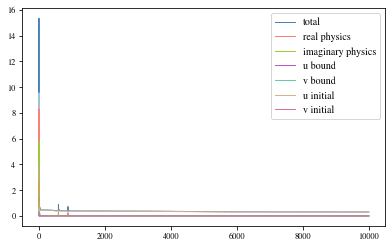

In [37]:
plt.plot(loss_epoch, label='total')
plt.plot(real_physics_loss_epoch, label='real physics')
plt.plot(imag_physics_loss_epoch, label='imaginary physics')
plt.plot(u_bound_loss_epoch, label='u bound')
plt.plot(v_bound_loss_epoch, label='v bound')
plt.plot(u_initial_loss_epoch, label='u initial')
plt.plot(v_initial_loss_epoch, label='v initial')
#plt.ylim(0, 0.001)
plt.legend(loc='upper right')

In [38]:
plt.close()

In [39]:
imageio.mimsave('waveguide.gif',images,fps=20)

<img src="waveguide.gif?2" width="750" align="center">

### Testing ground

In [40]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Checklist of bugfixing

### check physics

- [ ] PDEs correct?
- [ ] implementation correct?

### check code

- [ ] plotting correct?
- [ ] check every damn line of code (yay)

### does it work?

- [ ] yes